In [161]:
!pip install mat4py -q

In [ ]:
import math
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift, fftfreq
from scipy.signal import butter, sosfilt, sosfiltfilt
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

In [163]:
from mat4py import loadmat

data = loadmat('gdrive/MyDrive/ECGData.mat')
data = data['ECGData']

n_sigs = len(data['Data'])
sig_length = len(data['Data'][0])
ecg_sigs = np.empty((n_sigs, sig_length))
ecg_labs = np.empty(n_sigs, dtype='<U3')
for i in range(n_sigs):
    ecg_sigs[i] = data['Data'][i]
    ecg_labs[i] = data['Labels'][i][0]

In [164]:
def flatten_list(_list_):
  flat_list = []
  for l in _list_:
    for item in l:
      flat_list.append(item)
  return flat_list

Some of the time series present in the dataset do not correspond to ECG signals, as made obvious by the plots below:

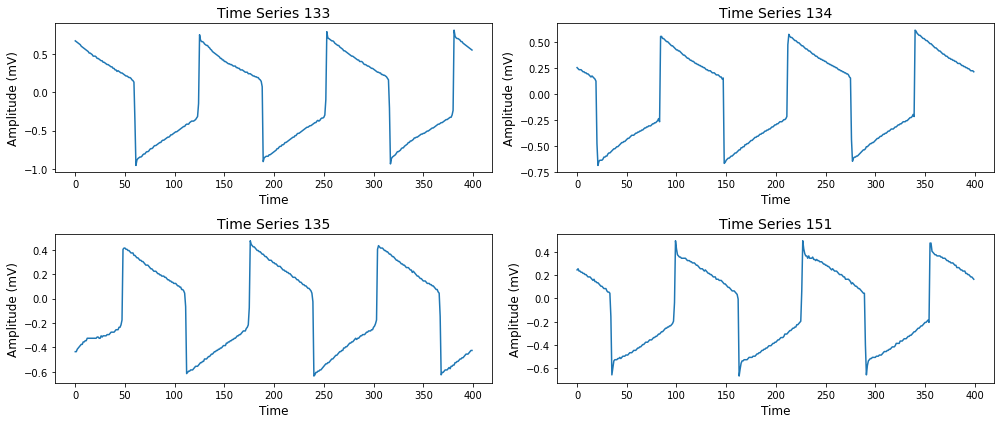

In [165]:
to_remove = [131, 132, 133, 134, 135, 151, 152, 153, 154, 155]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
for i, ax in enumerate(np.concatenate(axes)):
    ax.plot(ecg_sigs[to_remove[i+2]][:400])
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Amplitude (mV)', fontsize=12)
    ax.set_title('Time Series '+str(to_remove[i+2]), fontsize=14)
fig.tight_layout()
plt.show()

These time series are removed from the dataset:

In [166]:
ecg_sigs = ecg_sigs[[i for i in range(len(ecg_sigs)) if i not in to_remove]]
ecg_labs = ecg_labs[[i for i in range(len(ecg_labs)) if i not in to_remove]]
n_sigs = ecg_sigs.shape[0]

In [167]:
ecg_sigs_dict = {'Original': ecg_sigs}

$$\textbf{Exercise 1.}$$

$\text{Question 1)}$

The transfer function $\hat v$ of an ideal bandpass filter with frequency band $5-15Hz$ and applied to a signal of length $N$ with sampling frequency $f_{s} = 128Hz$ can be written as follows:

\begin{align*} \\
    \hat v(w) = \left\{
    \begin{array}{ll}
        1 \hspace{0.35 cm} if \hspace{0.35cm} 2 \pi \cdot \frac{5}{f_{s}} \leq |w| \leq 2 \pi \cdot \frac{15}{f_{s}} \hspace{0.25cm} \Leftrightarrow \hspace{0.25cm} \frac{5 \pi}{64} \leq |w| \leq \frac{15 \pi}{64}   \\[0.5 cm]
        0 \hspace{0.35 cm} otherwise
    \end{array}
    \right. \\
\\[1 cm]
\end{align*}

with $w = 2 \pi \cdot \frac{f}{f_{s}}$ and $f \in \{-f_{s}/2, ..., f_{s}/2 \}$.

This filter is implemented below.

$\text{Question 2)}$

In [168]:
class IdealBandPassFilter():
  def __init__(self, fs, fmin, fmax):
    self.fs = fs
    self.fmin = fmin
    self.fmax = fmax

  def filtering(self, x):
    x = fftshift(fft(x))
    freq = fftshift(fftfreq(x.size, d=1/self.fs))
    x[np.concatenate([np.where(abs(freq) < self.fmin)[0], 
                      np.where(abs(freq) > self.fmax)[0]])] = 0
    x = ifftshift(x)
    filtered_sig = ifft(x)
    return filtered_sig

In [169]:
ECG_Filter = IdealBandPassFilter(128, 5, 15)
ecg_sigs_filtered = np.empty(ecg_sigs.shape)
for i in range(n_sigs):
  ecg_sigs_filtered[i] = ECG_Filter.filtering(ecg_sigs_dict['Original'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [170]:
ecg_sigs_dict['Filtered (Ideal BPF)'] = ecg_sigs_filtered

$\text{Question 3)}$

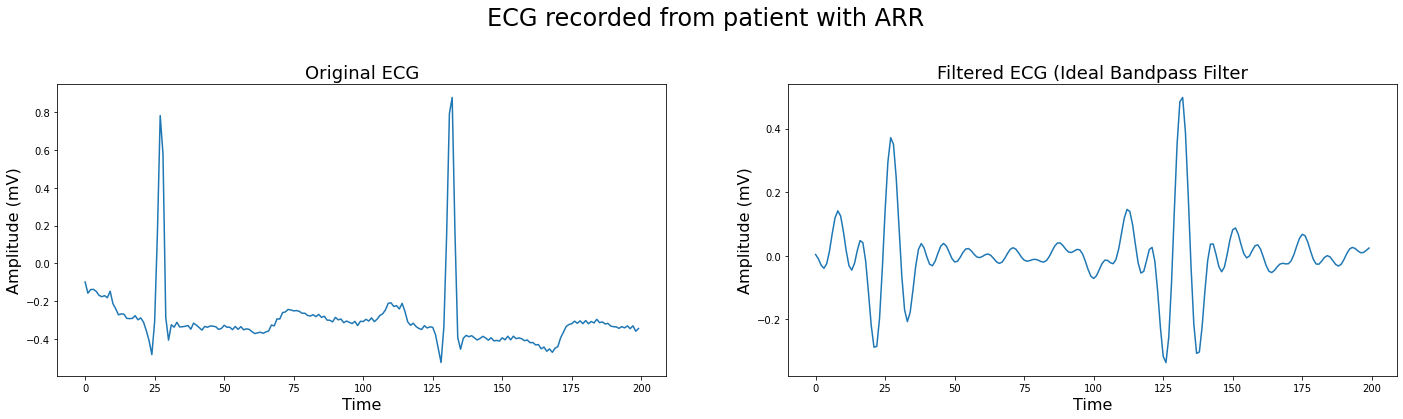

In [171]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
for i, ax in enumerate(list(axes)):
    ax.plot(ecg_sigs_dict[list(ecg_sigs_dict.keys())[i]][0][:200])
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Amplitude (mV)', fontsize=16)
    ax.set_title(['Original ECG', 'Filtered ECG (Ideal Bandpass Filter'][i], fontsize=18)
fig.subplots_adjust(top=0.8)
fig.suptitle('ECG recorded from patient with ARR\n', fontsize=24)
plt.show()

After having been filtered with an ideal filter with $5-15Hz$ passband the signal appears smoother. This is the result of high frequencies removal. Moreover the mean value of the signal has been shifted from approximately -0.3 to 0. Its range is also smaller. The shape of the QRS complex (the one located between 125 and 140 for example) is affected by the filtering. The Q- and S-waves are indeed made more apparent: the ratio size of the Q- (or S-) wave / size of the R-wave is much bigger in the filtered signal.

$$\textbf{Project (Part 1): QRS complex detection}$$

The QRS complex corresponds to the combination of three waves (Q, R and S) characterizing the depolarization of the ventricles of the heart. Its detection is made difficult by inter-individual variability in its shape, by the presence of high-frequency noise in the signal (coming from muscles electrical activity and power line interference for example) as well as by baseline wander. The first step of Elgendi et al.'s (2010) QRS detection algorithm consists in applying bandpass filtering to the signal. Bandpass filtering is performed using a second-order Butterworth bandpass filter. In what follows the passband is set to $8-20Hz$ as it is the frequency band that provides the best results. The coefficients of the filtered signal are then squared:

\begin{equation}
  y[n] = (x[n])^{2} \hspace{0.5 cm} \text{where x is the filtered signal}
\end{equation} 

This operation has the advantage of boosting large values. Following this, the limits of the QRS waves are spotted by using two moving averages. The first moving average, noted as $MA_{QRS}$, is used to identify the QRS area. Its expression is given by:

\begin{equation}
  MA_{QRS} = \frac{1}{W_{1}} (y[n-(W_{1}-1)/2] + ... + y[n] + ... + y[n+(W_{1}-1)/2])
  \hspace{0.5 cm} \text{where $W_{2}$ represents the approximate duration of a QRS complex} \\[0.25 cm]
\end{equation}

The second moving average, noted as $MA_{beat}$, is used to capture a complete hearbeat. Its expression is given by:

\begin{equation}
  MA_{QRS} = \frac{1}{W_{2}} (y[n-(W_{1}-1)/2] + ... + y[n] + ... + y[n+(W_{1}-1)/2]) \hspace{0.5 cm} \text{where $W_{2}$ represents the approximate length of an heartbeat} \\[0.25 cm]
\end{equation}

In their paper, Elgendi et al. (2010) set $W_{1} = 44$ and $W_{2} = 231$ when applying the algorithm to a signal sampled with sampling frequency $f_{s} = 360Hz$. Here $f_{s} = 128Hz$. $W_{1}$ and $W_{2}$ are therefore set here to $round((44 \times 128)/360)$ and $round((231 \times 128)/360)$ respectively.

$MA_{beat}$ is subsequently used as a threshold to detect the QRS complexes. The detection procedes as follows:

\begin{equation}
  if \hspace{0.5 cm} MA_{QRS}[n] > MA_{beat}[n] \\[0.1 cm]
  then \hspace{0.5 cm} Blocks[n] = 1 \\[0.1 cm]
  else \hspace{0.5 cm} Blocks[n] = 0 \\[0.25 cm]
\end{equation}

A thresholding procedure is then applied in order to remove too small blocks that are unlikely to correspond to QRS complexes, i.e. blocks of which duration is smaller than $W_{1}$.

Finally, R-peaks are identified by taking the argmax value within each blocks (after thresholding).

In [182]:
class QRSDetectionElgendi():
  """
  QRS complex detection using Elgendi et al.'s (2010) algorithm
  """
  def __init__(self, fs, band):
    self.fs = fs # sampling frequency
    self.band = band # passband
    self.butterworth = butter(N=1, Wn=self.band, btype='band', fs=self.fs, 
                              output='sos', analog=False) # Butterworth filter
    self.W1 = round(self.fs * 44 / 360)
    self.W2 = round(self.fs * 231 / 360)

  def filtering(self, sig):
    """
    Forward-Backward second-order Butterworth filtering
    ------------------------
    Parameters:
      sig: 1-dimensional ndarray. The signal to be filtered
    ------------------------
    Returns:
      The filtered signal
    """
    sig = sosfiltfilt(self.butterworth, sig) # sosfiltfilt doubles the order of the filter
    return sig

  def W1_integration(self, x):
    """
    First moving average
    ------------------------
    Parameters:
      x: 1-dimensional ndarray. The time series to which the moving average is
          applied
    ------------------------
    Returns:
      Time series of length x.size-round(W1/2)
    """
    x = x**2
    x = 1/self.W1 * np.array([sum(x[(n+1-self.W1):(n+1)]) for n in range(x.size)])
    x = x[round(self.W1/2):]
    return x

  def W2_integration(self, x):
    """
    Second moving average
    ------------------------
    Parameters:
      x: 1-dimensional ndarray. The time series to which the moving average is
          applied
    ------------------------
    Returns:
      Time series of length x.size-round(W2/2)
    """
    x = x**2
    x = 1/self.W2 * np.array([sum(x[(n+1-self.W2):(n+1)]) for n in range(x.size)])
    x = x[round(self.W2/2):]
    return x

  def segment_blocks(self, x):
    """
    Detect blocks of ones from a binary time series
    """
    x = np.where(x == 1)[0]
    blocks = [[x[0]]]
    for i in range(1, x.shape[0]):
      if x[i] == x[i-1]+1:
        blocks[[blocks.index(b) for b in blocks if x[i-1] in b][0]].append(x[i])
      else:
        blocks.append([x[i]])
    return blocks

  def thresholding(self, x):
    """
    Thresholding function: remove blocks of which length is smaller than W1
    """
    blocks = self.segment_blocks(x)
    blocks = [b for b in blocks if len(b) >= self.W1]
    return blocks

  def blocks_detection(self, x):
    """
    Detection of QRS blocks using the procedure detailed above
    """
    x = self.filtering(x)
    x1, x2 = self.W1_integration(x), self.W2_integration(x)
    x = x1[:x2.size] > x2
    x = np.array(x, dtype=int)
    x = flatten_list(self.thresholding(x))
    x = [1 if i in x else 0 for i in range(len(x))]
    return x

  def r_peaks_detection(self, x):
    """
    Detection of R-peaks locations in a given signal by taking the argmax
      value of each QRS block
    """
    x = self.filtering(x)
    x1, x2 = self.W1_integration(x), self.W2_integration(x)
    blocks = x1[:x2.size] > x2
    blocks = np.array(blocks, dtype=int)
    blocks = self.thresholding(blocks)
    peaks = [b[0] + np.argmax(x1[b]) for b in blocks]
    return peaks

In [ ]:
ECG_ElgendiAnalysis = QRSDetectionElgendi(128, [8, 20])
ecg_sigs_filt_butter = np.empty(ecg_sigs_dict['Original'].shape)
for i in range(n_sigs):
  ecg_sigs_filt_butter[i] = ECG_ElgendiAnalysis.filtering(ecg_sigs_dict['Original'][i])

In [ ]:
ecg_sigs_dict['Filtered (Butterworth)'] = ecg_sigs_filt_butter

In [ ]:
n_classes = np.unique(ecg_labs, return_counts=True)[0].shape[0]
n_inds_per_class = np.unique(ecg_labs, return_counts=True)[1].astype(int)
class_limits = np.insert(np.cumsum(n_inds_per_class), 0, 0)

In [ ]:
ECG_ElgendiAnalysis = QRSDetectionElgendi(128, [8, 20])
ex_W1_int = []
ex_W2_int = []
ex_blocks = []
ex_r_peaks = []
for i in range(len(class_limits)-1):
  ex_W2_int.append(ECG_ElgendiAnalysis.W2_integration(ecg_sigs_dict['Filtered (Butterworth)'][class_limits[i]]))
  ex_W1_int.append(ECG_ElgendiAnalysis.W1_integration(ecg_sigs_dict['Filtered (Butterworth)'][class_limits[i]])[:len(ex_W2_int[i])])
  ex_blocks.append(ECG_ElgendiAnalysis.blocks_detection(ecg_sigs_dict['Original'][class_limits[i]]))
  ex_r_peaks.append(ECG_ElgendiAnalysis.r_peaks_detection(ecg_sigs_dict['Original'][class_limits[i]]))

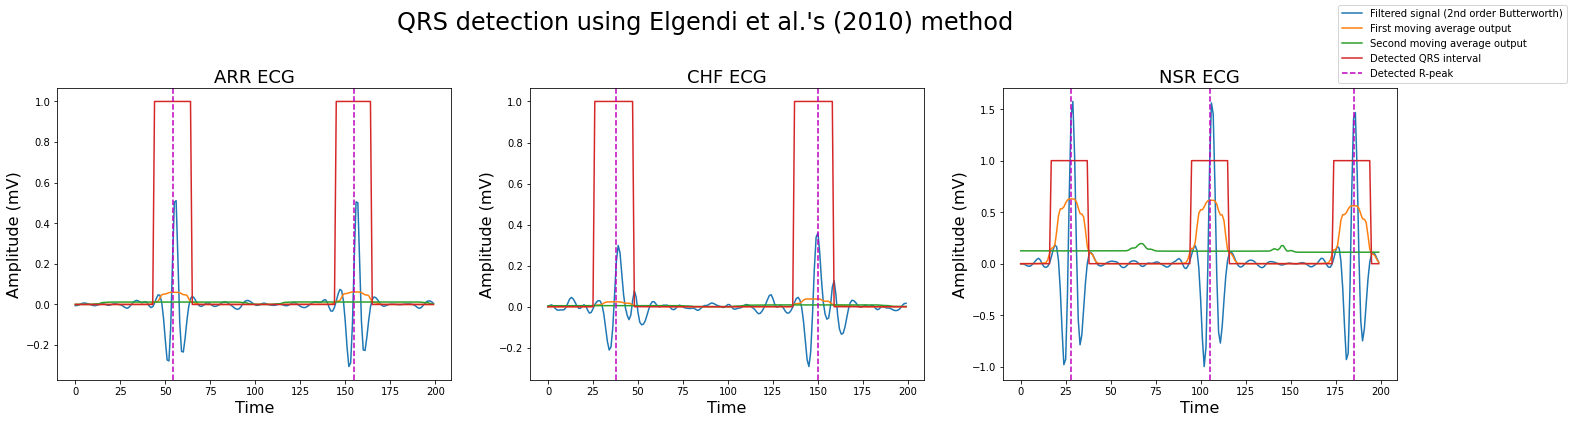

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=n_classes, figsize=(24, 6))
for i, ax in enumerate(list(axes)):
    ax.plot(ecg_sigs_dict['Filtered (Butterworth)'][class_limits[i]][180:380])
    ax.plot(ex_W1_int[i][180:380])
    ax.plot(ex_W2_int[i][180:380])
    ax.plot(ex_blocks[i][180:380])
    for p in [r for r in ex_r_peaks[i] if r>180 and r<380]:
        ax.axvline(x=p-180, linestyle='--', color='m')
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Amplitude (mV)', fontsize=16)
    ax.set_title(str(ecg_labs[class_limits[i]])+' ECG', fontsize=18)
fig.legend(['Filtered signal (2nd order Butterworth)', 'First moving average output', 
            'Second moving average output', 'Detected QRS interval', 'Detected R-peak'])
fig.suptitle('QRS detection using Elgendi et al.\'s (2010) method', fontsize=24)
fig.subplots_adjust(top=0.8)
plt.show()

These graphs show that both the QRS complex and the R-peaks are spotted with great accuracy.

$$\textbf{Project (Part 2): ECG classification}$$

In [ ]:
!pip install scaleogram -q

In [ ]:
import pywt
import scaleogram as scg

According to WHO, cardiovascular diseases accounted for 32% of deaths worldwide in 2019. Designing methods to accurately diagnose them is therefore a pressing issue. The project here focuses on the detection of arrythmia and congestional heart failure from ECGs, which correspond to recordings of the electrical activity of the heart. ECG classification necessitates extracting meaningful features from the signal. The raw signal only offers temporal information. On the other hand the Fourier Transform provides with frequency information only. Wavelet transformation of the signal allows to get both ways by representing it in the time-frequency domain.

The wavelet transform assesses the similarity between a signal $g$ and a motif $\Psi$ (referred to as the mother wavelet) dilated (or contracted) by a factor $a$ (the scale) at each time point. The formula of the wavelet transform is given by:

\begin{equation}
  \tilde g_{\psi}(t, a) = \int_{R} g(u) |a|^{-\frac{1}{2}} \overline{\psi} (a(u-t))du = \langle g, |a|^{-\frac{1}{2}} \psi (a^{-1} (\cdot -t))\rangle
\end{equation}

A scaleogram corresponds to a graph $\{(t, a), (|\tilde g_{\psi} (t, a)|^{2} \}$ with time represented on the x-axis and the scale values on the y-axis.

The relation between scales ($a$) and frequencies ($f$) is given by:

\begin{equation}
  f = \frac{f_{c}}{a} \hspace{0.5 cm} \text{where $f_{c}$ is the central frequency of the mother wavelet}
\end{equation}

For a discrete signal this relation becomes:

\begin{equation}
  f = \frac{f_{c}*f_{s}}{a} \hspace{0.5 cm} \text{where $f_{s}$ is the sampling frequency}
\end{equation}

The last relation must be taken into account when defining the y-axis of a scaleogram. Moreover, when computing the wavelet transform of a signal of size $N$, the maximum scale value must be set such that:

\begin{equation}
  \frac{1}{N} = \frac{f_{c}}{a} \hspace{0.25 cm} \Leftrightarrow \hspace{0.25 cm} a = f_{c} * N
\end{equation}

otherwise the period of the wavelet for the maximum scale value will be bigger than $N$, making the wavelet coefficients less reliable.

In [ ]:
wavedict = {'Continuous': ['mexh', 'morl'], 'Discrete': ['db4']}
wavelets = [item for sublist in list(wavedict.values()) for item in sublist]

In [179]:
class WaveletAnalysis():
  def __init__(self, mother, fs, sig_length, n_scales_disc=None, wavedict=wavedict):
    self.mother = mother
    self.fs = fs
    self.wavedict = wavedict
    self.sig_length = sig_length
    self.n_scales_disc = n_scales_disc

  def get_coefficients(self, sig):
    """
    Parameters:
      sig: 1-dimensional ndarray. The signal to be decomposed in the time-frequency domain
    ------------------------
    Returns:
      coefs: 2-dimensional ndarray of size (mother wavelet's central frequency * sig_length) * sig_length. 
          The wavelet transform of the input signal
      freqs (if continuous mother wavelet): 1-dimensional ndarray of size n_scales (mother wavelet's central frequency * sig_length).
          Frequencies for which the continuous wavelet transformation is performed
    ------------------------
    Wavelet periods bigger than the length of the signal are discarded
        since the coefficients computed for these periods may be unreliable
        hence scales = np.arange(1, (self.sig_length * pywt.central_frequency(self.mother))+1)
    """
    sig = sig[:self.sig_length]
    if self.mother in self.wavedict['Continuous']:
        coefs, freqs = pywt.cwt(sig, np.arange(1, (self.sig_length * pywt.central_frequency(self.mother))+1), 
                                self.mother, sampling_period=1/self.fs)
        return coefs, freqs
    elif self.mother in self.wavedict['Discrete']:
        coefs = pywt.wavedec(x, self.mother, mode='periodization')[1:]
        coefs = coefs[:self.n_scales_disc] if self.n_scales_disc != None else coefs
        coefs = [item for sublist in coefs for item in sublist]
        return coefs

  def get_scaleogram(self, sig, siglab):
    """
    Draw the scaleogram of a signal for a given sig_length (see get_coefficients function)
    ------------------------
    Parameters:
      sig: 1-dimensional ndarray. The signal to be decomposed in the time-frequency domain
      siglab: the class the ECG signal belongs to
    """
    if self.mother in self.wavedict['Continuous']:
        time = np.arange(1, self.sig_length+1)
        coefs, freqs = self.get_coefficients(sig)
        period = 1 / freqs
        power = abs(coefs) ** 2
        levels = np.arange(0, max(power.flatten())*100+1)/100
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
        im = ax.contourf(time, np.log2(period), power, levels, extend='neither', cmap='jet')
        yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_title
        ax.set_xlabel('Time', fontsize=18)
        ax.set_ylabel('Period (in seconds)', fontsize=18)
        ax.set_title('Scaleogram of an ECG signal from a patient with '+siglab, fontsize=24)
        cbar_ax = fig.add_axes([0.95, 0.25, 0.04, 0.5])
        fig.colorbar(im, cax=cbar_ax)
        plt.show()
    elif self.mother in self.wavedict['Discrete']:
        raise ValueError('Not implemented yet')
        #coefs = self.get_coefficients(sigs[:self.sig_length])
        #scaleogram = abs(np.array([np.repeat(coefs[-c], 2**c)[:sig_length] for c in range(1, len(coefs)+1)]))**2
        #scaleogram = plt.imshow(abs(scaleogram)**2, aspect='auto', cmap='jet')

The wavelet function which shape is closest to the shape of the QRS complex is the 'Mexican Hat' wavelet (see figure below). The 'Mexican Hat' mother wavelet function is defined as:

\begin{equation}
  \psi (t) = \frac{2}{\sqrt{3} \sqrt[4]{\pi}} \exp \Big( -\frac{t^{2}}{2} \Big) \big( 1 - t^{2} \big)
\end{equation}

Since the QRS complex is the one of the most important features of the ECG signal this wavelet is taken as the mother wavelet when extracting the scaleograms. 

Text(0.5, 1.0, 'Mexican Hat wavelet for different values of a')

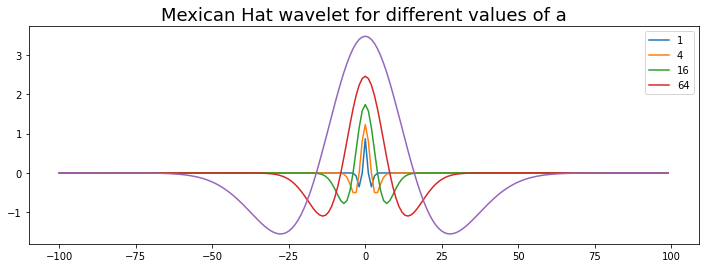

In [246]:
def mexican_hat(t):
  return (2 / (math.sqrt(3) * math.pi**(1/4))) * np.exp(-t**2 / 2) * (1 - t**2)

x = np.arange(-100, 100)

plt.figure(figsize=(12,4))
for a in [1, 2, 4, 8, 16]:
  plt.plot(x, a**(1/2) * mexican_hat(x/a))
plt.legend([str(a) for a in [1, 4, 16, 64]])
plt.title('Mexican Hat wavelet for different values of a', fontsize=18)

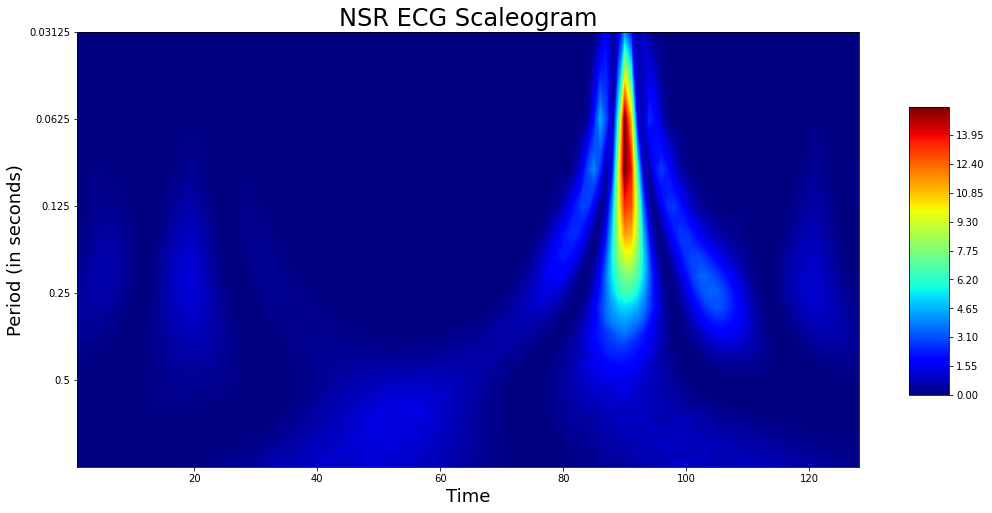

In [160]:
ECG_WaveletAnalysis = WaveletAnalysis(wavedict['Continuous'][0], 128, 128)
ECG_WaveletAnalysis.get_scaleogram(ecg_sigs_dict['Original'][150], ecg_labs[150])

ECG scaleograms can be used as inputs to a neural network in order to classify ECG signals as being recorded from patients with arrythimia (ARR), congestional heart failure (CHF) or normal sinus rhythm (NSR). In what follows a deep dense neural networks is used. This network is made of one input layer taking scaleograms and information about heartbeat variability as entries (see below), two densely connected layers with 300 and 100 units respectively, and an output layer. ReLU activation functions are applied to the outputs of the input layer and of the first dense layer. The Softmax activation function is applied to the output of the last dense layer to estimate the probabilities of an observation belonging to each of the three classes.

Contrary to convolutional neural networks dense neural networks are not shift-invariant: two similar motifs at different locations will not necessarily be interpreted the same way. This is particularly problematic in the case of ECG classification given the inter-individual variation in heartbeat duration. If a segment of ECG signal contain more than one heartbeat then the second (and third, fourth, etc.) R-peaks locations will differ from one individual to the next. This means that a large amount of intra-class variability may be introduced in the data to be fed to the neural network simply because of hearbeat duration variability. It is therefore necessary to design the scaleograms dataset such that they contain only one heartbeat each, and with the R-peak always at the same location. In doing so, variability will be mostly related to meaningful features of the ECG signals (such as the QRS complex or the T-wave shapes). To achieve this, the QRS detection algorithm designed by Elgendi et al. (2010) is used to identify the R-peaks locations for each individual signal. Each signal is then segmented into a series of single heartbeats by taking, for each R-peak, the 50 points preceding it and the 78 following it. Following this a sampling procedure is performed, whereby a limited number of segments are kept for each individual. Scaleograms are then extracted from these segments of ECG signals.

Another issue relative to the ECG signals dataset is class imbalance. The number of signals recorded from subjects suffering from ARR far outweighs that of subjects with CHF or NSR (96, 30 and 36 and 30 respectively). Class imbalance may be detrimental to the performance of the model by making it learn to decrease entropy by always predicting the dominant class. Rebalancing the classes is necessary. The number of samples taken from each individual is therefore made dependent upon the class each individual belongs to. In the following 50 samples are taken from subjects with ARR, 160 from subjects with CHF and 180 from subjects with NSF. This results in a balanced dataset.
The segments of ECG signals are then transformed into scaleograms via continuous wavelet transform, using the ‘Mexican Hat’ wavelet as the mother wavelet (for the same reasons stated above).

An important feature of ECG signals recorded from patients with ARR is their variability in heartbeat duration. This information is absent from the one-heartbeat scaleograms. It seems interesting to provide this information to the model as it would help it better discriminate individuals with ARR. This is done by concatenating a given flattened scaleogram with a one-size vector storing the hearbeat variance of the individual from which the scaleogram was extracted.

The performance of the model is assessed using 5-fold cross-validation. Importantly, if a subject is selected for the training dataset then all scaleograms extracted from their ECG recording are included in the training dataset. This avoids testing the model on data it has been trained on and therefore overestimating its performance. Model's accuracy, F1 scores and the confusion matrix are computed after the five simulations.


In [173]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
import torchvision.transforms as transforms
import math
import random
import time

In [180]:
class ECGScaleogramDataset(WaveletAnalysis, QRSDetectionElgendi):
  """
  Class to design the training and testing dataset based on the extraction of
      scaleograms and hearbeat duration variances from the individuals' ECG signals
  """
  def __init__(self, fs, mother, sig_length, filt, n_samples_per_ind, batch_size, k):
    WaveletAnalysis.__init__(self, mother, fs, sig_length)
    QRSDetectionElgendi.__init__(self, fs, band=[8, 20])
    
    self.filt = filt
    self.r_peaks = None
    
    self.n_classes = None
    self.n_inds = None
    self.class_limits = None
    self.n_inds_per_class = None
    self.n_samples_per_ind = n_samples_per_ind
    self.full_sig_length = None
    
    self.labels = None
    self.train_indices = None
    self.test_indices = None
    self.train_size = None
    self.test_size = None
    self.batch_size = batch_size
    self.k = k

    self.n_sim = 0

  def extract_data_info(self, sigs, labels):
    """
    Computes:
      n_classes: the number of classes in the dataset
      n_inds_per_class: the number of subjects belonging to each class
      class_limits: the boundaries of each class
      n_inds: the total number of subjects in the dataset
      full_sig_length: the total length of the signal
      labels: array of class labels
      r_peaks: 2-dimensional ndarray storing the locations of the R-peaks for each
          individual (using Elgendi et al.'s (2010) method)
    """
    self.n_classes = np.unique(labels, return_counts=True)[0].shape[0]
    self.n_inds_per_class = np.unique(labels, return_counts=True)[1].astype(int)
    self.class_limits = np.insert(np.cumsum(self.n_inds_per_class), 0, 0)
    self.n_inds = sigs.shape[0]
    self.full_sig_length = sigs.shape[1]
    self.labels = np.array(flatten_list([[lab] * self.n_inds_per_class[i] #* self.n_samples_per_ind 
                                         for lab, i in enumerate(range(self.n_classes))]))
    self.r_peaks = np.array([self.r_peaks_detection(sigs[i]) for i in range(self.n_inds)])

  def extract_heartbeat_var(self):
    """
    Computes each individual's heartbeat variability as the (standardized) variance in R-peak-to-R-peak distance
    """
    r_peaks_intervals = [[self.r_peaks[i][p+1]-self.r_peaks[i][p] for p in range(len(self.r_peaks[i])-1)]
                         for i in range(self.n_inds)]
    hbeat_var = np.array([np.var(r_peaks_intervals[i] / np.mean(r_peaks_intervals[i])) 
                          for i in range(self.n_inds)])
    hbeat_var = (hbeat_var - min(hbeat_var)) / (max(hbeat_var) - min(hbeat_var))
    return hbeat_var

  def sample_data_by_subj(self, sigs, single_r_peak):
    """
    Parameters:
      sigs: 2-dimensional arrays storing the ECG signals
      single_r_peaks: boolean. If True each extracted segment of an individual
          signal will contain a single R-peak. This R-peak is always located at
          the same position.
    ------------------------
    Returns:
      sigs: the one-heartbeat segments of each individual's ECG signal
    """
    if self.filt:
        sigs = self.filtering(sigs)
    if single_r_peak:
        if self.sig_length != 128:
            raise ValueError('sig_length must be set to 128')
        sigs = [[sigs[i][(p-50):(p+78)] for p in self.r_peaks[i][1:-1]] for i in range(self.n_inds)]
        sigs = [np.array(sigs[i])[random.sample(range(len(sigs[i])), self.n_samples_per_ind[np.where(self.class_limits<=i)[0][-1]])]
                for i in range(self.n_inds)]
    else:
        sigs = [np.array(np.array_split(sigs[i], self.full_sig_length/self.sig_length))
             for i in range(self.n_inds)] 
        sigs = [sigs[i][random.sample[range(int(self.full_length/self.sig_length)), 
                                self.n_samples_per_ind[np.where(self.class_limits<=i)[0][-1]]]] for i in range(self.n_inds)]
    return sigs

  def stratified_kfold_partition(self, rand_inds):
    """
    Creates for each simulation the training and testing groups
    """
    self.n_sim += 1
    if self.n_sim < self.k:
        self.test_indices = [rand_inds[cls][(self.n_sim-1)*i:self.n_sim*i] 
                             for cls, i in enumerate(np.round(self.n_inds_per_class / self.k).astype(int))]
    elif self.n_sim == self.k:
        self.test_indices = [rand_inds[cls][(self.n_sim-1)*i:self.n_inds_per_class[cls]] 
                             for cls, i in enumerate(np.round(self.n_inds_per_class / self.k).astype(int))]
    else:
        raise ValueError('No more simulation is required')
    self.test_indices = flatten_list(self.test_indices)
    self.train_indices = [ind for ind in range(self.n_inds) if ind not in self.test_indices]
  
  def split_data(self, x):
    """
    Parameters:
      x: 3-dimensional array of spectrograms. x is of size (total number
          of samples) * (mother wavelet's central frequency * sig_length) * sig_length
    ------------------------
    Computes:
      train_size: number of train_indices computed with the stratified_kfold_partition
          method for a given simulation multiplied by the number of samples
          extracted from each individual
      test_size: number of test_indices computed with the stratified_kfold_partition
          method for a given simulation multiplied by the number of samples
          extracted from each individual
    ------------------------
    Returns:
      x_train_scgs: training dataset of size train_size * (mother wavelet's central frequency * sig_length) * sig_length
      x_test_scgs: testing dataset of size test_size * (mother wavelet's central frequency * sig_length) * sig_length
      x_train_labels: 1-dimensional ndarray of size train_size storing training labels
      x_test_labels: 1-dimensional ndarray of size train_size storing testing labels
    """
    self.train_size = sum([self.n_samples_per_ind[np.where(self.class_limits<=i)[0][-1]] for i in self.train_indices])
    self.test_size = sum([self.n_samples_per_ind[np.where(self.class_limits<=i)[0][-1]] for i in self.test_indices])

    x_train_scgs, x_test_scgs = np.concatenate([x[i] for i in self.train_indices]), np.concatenate([x[i] for i in self.test_indices])
    x_train_scgs = x_train_scgs.reshape((self.train_size, x_train_scgs.shape[1], x_train_scgs.shape[2]))
    x_test_scgs = x_test_scgs.reshape((self.test_size, x_test_scgs.shape[1], x_test_scgs.shape[2]))

    x_train_labels = np.concatenate([np.repeat(self.labels[i], self.n_samples_per_ind[np.where(self.class_limits<=i)[0][-1]]) 
                                     for i in self.train_indices])
    x_test_labels = np.concatenate([np.repeat(self.labels[i], self.n_samples_per_ind[np.where(self.class_limits<=i)[0][-1]]) 
                                    for i in self.test_indices])
    
    return x_train_scgs, x_test_scgs, x_train_labels, x_test_labels

  def loader(self, x_train_scgs, x_test_scgs, x_train_labels, x_test_labels):
    """
    Create torch-readable x_train and x_test dataset containing for each sample
        taken from a given individual the scaleogram, the individual's heartbeat
        duration variability and their label
    ------------------------
    Parameters:
      x_train_scgs
      x_test_scgs
      x_train_labels
      x_test_labels
    ------------------------
    Returns:
      x_train: DataLoader object
      x_test: DataLoader object
    """
    hbeat_var = self.extract_heartbeat_var()
    x_train_hbeat_var = np.concatenate([np.repeat(hbeat_var[i], self.n_samples_per_ind[np.where(self.class_limits<=i)[0][-1]]) 
                                        for i in self.train_indices])
    x_test_hbeat_var = np.concatenate([np.repeat(hbeat_var[i], self.n_samples_per_ind[np.where(self.class_limits<=i)[0][-1]]) 
                                       for i in self.test_indices])

    x_train = TensorDataset(torch.Tensor(x_train_scgs).unsqueeze(1),
                            torch.Tensor(x_train_hbeat_var).unsqueeze(1), 
                            torch.Tensor(x_train_labels).type(torch.LongTensor))
    x_test = TensorDataset(torch.Tensor(x_test_scgs).unsqueeze(1),
                           torch.Tensor(x_test_hbeat_var).unsqueeze(1), 
                           torch.Tensor(x_test_labels).type(torch.LongTensor))
    x_train = DataLoader(x_train, shuffle=True, batch_size=self.batch_size)
    x_test = DataLoader(x_test, shuffle=True, batch_size=1)
    return x_train, x_test

In [194]:
class DenseNet(nn.Module):
  """
  Dense Neural Network
  ------------------------
  Parameters:
    n_classes: number of classes
    size_size: size of the flattened scaleogram
  """
  def __init__(self, n_classes, scg_size):
    super(DenseNet, self). __init__()
    self.dense1 = nn.Linear(scg_size+1, 300)
    self.dense2 = nn.Linear(300, 100)
    self.dense3 = nn.Linear(100, n_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self, scg, hbeat_var):
    x = self.dense1(torch.cat((scg, hbeat_var), 1))
    x = self.relu(x)
    x = self.dense2(x)
    x = self.relu(x)
    x = self.dense3(x)
    output = self.softmax(x)
    return output

In [176]:
wavelets = ['mexh']

In [ ]:
k = 5 # 5-fold cross-validation

torch.manual_seed(0) # for reproducible results

lr = 0.005
n_epochs = 30

training_history_dense = {'loss':np.empty((len(wavelets), k, n_epochs)), 
                        'acc':np.empty((len(wavelets), k, n_epochs))}
test_results_dense = {'loss':np.empty((len(wavelets), k)), 
                      'acc':np.empty((len(wavelets), k))}
true_classes = []
predicted_classes = []

for w_index, w in enumerate(wavelets):
    ECG_ScgData = ECGScaleogramDataset(128, w, 128, False, [50, 160, 180], 64, 5)
    ECG_ScgData.extract_data_info(ecg_sigs_dict['Original'], ecg_labs)
    strat_shuffled_indices = [random.sample(range(ECG_ScgData.class_limits[j], ECG_ScgData.class_limits[j+1]), 
                              round(ECG_ScgData.n_inds_per_class[j])) for j in range(ECG_ScgData.n_classes)]
  
    ecg_sig_sample = ECG_ScgData.sample_data_by_subj(ecg_sigs_dict['Original'], single_r_peak=True)
    X_full = []
    for ind in range(len(ecg_sig_sample)):
        scgs = []
        for sample in range(len(ecg_sig_sample[ind])):
            cwt_coefs, _ = ECG_ScgData.get_coefficients(ecg_sig_sample[ind][sample])
            scgs.append(cwt_coefs)
        X_full.append(scgs)
        
    # Normalization of the cwt coefficients
    mean_cwt_coef = np.mean((flatten_list(X_full)))
    std_cwt_coef = np.std((flatten_list(X_full)))
    for ind in range(len(ecg_sig_sample)):
        for sample in range(len(ecg_sig_sample[ind])):
            X_full[ind][sample] = (X_full[ind][sample] - mean_cwt_coef) / std_cwt_coef

    for sim in range(k):
        ECG_ScgData.stratified_kfold_partition(strat_shuffled_indices)
        X_train_scgs, X_test_scgs, X_train_labels, X_test_labels = ECG_ScgData.split_data(X_full)

        X_train, X_test = ECG_ScgData.loader(X_train_scgs, X_test_scgs, X_train_labels, X_test_labels)

        train_steps = ECG_ScgData.train_size // ECG_ScgData.batch_size

        dense_model = DenseNet(ECG_ScgData.n_classes,
                               int(pywt.central_frequency(ECG_ScgData.mother)*ECG_ScgData.sig_length**2)) # new untrained dense network
        optimizer_dense = torch.optim.SGD(dense_model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(n_epochs):
            train_loss, train_correct = 0.0, 0
            dense_model.train()
            for _, (scgs, hbvars, labels) in enumerate(X_train): # Training on mini-batches
                scgs = scgs.view(-1, int(pywt.central_frequency(ECG_ScgData.mother)*ECG_ScgData.sig_length**2))
                optimizer_dense.zero_grad()
                output = dense_model.forward(scgs, hbvars)
                loss = criterion(output, labels)
                loss.backward()
                optimizer_dense.step()
                train_loss += loss.item()
                scores, predictions = torch.max(output.data, 1)
                train_correct += (predictions == labels).sum().item()
            training_history_dense['loss'][w_index, sim, epoch] = train_loss / train_steps
            training_history_dense['acc'][w_index, sim, epoch] = train_correct / ECG_ScgData.train_size

        test_loss, test_correct = 0.0, 0
        dense_model.eval()
        for scgs, hbvars, labels in X_test: # Evaluation on the test dataset
            scgs = scgs.view(-1, int(pywt.central_frequency(ECG_ScgData.mother)*ECG_ScgData.sig_length**2))
            output = dense_model.forward(scgs, hbvars)
            loss = criterion(output, labels)
            test_loss += loss.item()
            scores, predictions = torch.max(output.data, 1)
            test_correct += (predictions == labels).sum().item()
            true_classes.append(int(labels))
            predicted_classes.append(int(predictions))
        test_results_dense['loss'][w_index, sim] = test_loss / ECG_ScgData.test_size
        test_results_dense['acc'][w_index, sim] = test_correct / ECG_ScgData.test_size

In [ ]:
print(training_history_dense['acc'][0])

In [226]:
print('The mean accuracy on the testing dataset is equal to '+ str(round(np.mean(test_results_dense['acc'][0]), 2)) + '.')

The mean accuracy on the testing dataset is equal to 0.7.


In [217]:
confusion_matrix = np.zeros((ECG_ScgData.n_classes, ECG_ScgData.n_classes))
for sim in range(k):
  for true, predicted in zip(true_classes, predicted_classes):
    confusion_matrix[true, predicted] += 1
for cls in range(ECG_ScgData.n_classes):
  confusion_matrix[cls, :] /= sum(confusion_matrix[cls, :]) #class-wise normalization

In [218]:
print(confusion_matrix)

[[0.71145833 0.17208333 0.11645833]
 [0.38395833 0.55833333 0.05770833]
 [0.13141026 0.03675214 0.83183761]]


Lines correspond to the 'true classes' and columns to the 'predicted classes'.

In [225]:
average_test_accuracy = np.mean(test_results_dense['acc'][0])
f1_scores = []
for cls in range(n_classes):
  precision = confusion_matrix[cls, cls] / (confusion_matrix[cls, cls] + sum(confusion_matrix[[i for i in range(n_classes) if i !=cls], cls]))
  recall = confusion_matrix[cls, cls] / (confusion_matrix[cls, cls] + sum(confusion_matrix[cls, [i for i in range(n_classes) if i !=cls]]))
  f1_scores.append((2*precision*recall) / (precision+recall))
print('The F1 scores are: ' + str(round(f1_scores[0], 2)) + ', ' + str(round(f1_scores[1], 2)) + ', ' + str(round(f1_scores[2], 2)) + '.')

The F1 scores are: 0.64, 0.63, 0.83.


Elgendi et al.'s (2010) QRS detection algorithm's excellent performance has been replicated here. Moreover, it has been shown that this algorithm can be used for ECG signal segmentation. By spotting R-peaks locations it is possible to isolate single heartbeats. This allows for building a dataset of standardized segments of ECG signals where the R-peak is always at the location. The advantage of this procedure is to ensure that the scaleograms extracted later from these segments differ only in relation to meaningful time-frequency features.

The neural network's performance is moderate, especially when classifying ECG signals recorded from patients with ARR or CHF (F1 scores of 0.64 and 0.63 respectively, compared to 0.83 for ECG from patient with NSR). This is particularly problematic as under-detection of cardiovascular diseases can have dramatic consequences.

As shown in the confusion matrix, most of the errors made when classifying ECG from patients with CHF consist in classifying them as ECGs from patients with ARR: P(Predicted=ARR | True=CHF) = 0.38, compared to P(Predicted=NSR | True=CHF) = 0.06. The reverse also holds to some extent: P(Predicted=CHF | True=ARR) = 0.17, compared to P(Predicted=NSR | True=ARR) = 0.12. It is likely that features that could differentiate them are missing from the data fed to the neural network. These could be related to low-frequency components to the extent that this information is absent from scaleograms with lowest frequency equal to $1Hz$. It may be worth taking 256-seconds segments from the ECG signals as it would give access to wavelet transform coefficients computed at lower frequencies. However, this would also mean being confronted with the problem of heartbeat duration variability described above.

Another possible interpretation of the poor accuracy of the model when classifying pathological ECGs is that the model only learns to discriminate pathological from non-pathological ECGs. When inspecting the scaleograms from both groups it appears that the high-frequency wavelet transform coefficients located around the R-peak time of occurence are low compared to their counterparts extracted from non-pathological ECGs. The model may therefore only learn to detect when an ECG contains QRS complexes of which shape is similar to the shape of the 'Mexican Hat' wavelet and when it does not. This would explain the pattern of errors described above. Improving pathology detection may require giving more importance to features other than the QRS complex. This again points to the downsides of looking at one-heartbeat segments of ECG.

Here the neural network takes images (scaleograms) as inputs (and information about heartbeat duration variability). An interesting avenue to explore would be to use a convolutional (instead of a dense) neural network to classify the ECG signals. Scaleograms could be fed to a convolutional neural network which outputs would later be concatenated with information about hearbeat variability, similarly to what is done in Wang et al. (2020).

$$\textbf{References}$$

Elgendi, M., Jonkman, M., & Boer, F.D. (2010). Frequency Bands Effects on QRS Detection. BIOSIGNALS.

Wang, T., Lu, C., Sun, Y., Yang, M., Liu, C., & Ou, C. (2021). Automatic ECG Classification Using Continuous Wavelet Transform and Convolutional Neural Network. Entropy, 23.